### Simple LSTM regression with Tensorflow

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

### Data preprocessing

In [2]:
co2 = fetch_openml(data_id=41187, as_frame=True)
dataset = co2.frame[['co2']]

# Min/Max scaling
dataset_max = dataset.max().values
dataset_min = dataset.min().values

def unscale(dataset):
    return dataset * (dataset_max - dataset_min) + dataset_min

def scale(dataset):
    return (dataset - dataset_min) / (dataset_max - dataset_min)

dataset = scale(dataset)

In [3]:
train, test = train_test_split(dataset, test_size=0.1, shuffle=False)

In [4]:
window_size = 12

In [5]:
train.shift(periods=range(window_size)).dropna()

,co2_0,co2_1,co2_2,co2_3,co2_4,co2_5,co2_6,co2_7,co2_8,co2_9,co2_10,co2_11
11,0.041051,0.039409,0.045977,0.045977,0.080460,0.073892,0.064039,0.055829,0.073892,0.075534,0.070608,0.050903
12,0.042693,0.041051,0.039409,0.045977,0.045977,0.080460,0.073892,0.064039,0.055829,0.073892,0.075534,0.070608
13,0.034483,0.042693,0.041051,0.039409,0.045977,0.045977,0.080460,0.073892,0.064039,0.055829,0.073892,0.075534
14,0.032841,0.034483,0.042693,0.041051,0.039409,0.045977,0.045977,0.080460,0.073892,0.064039,0.055829,0.073892
15,0.018062,0.032841,0.034483,0.042693,0.041051,0.039409,0.045977,0.045977,0.080460,0.073892,0.064039,0.055829
...,...,...,...,...,...,...,...,...,...,...,...,...
1997,0.796388,0.814450,0.825944,0.825944,0.834154,0.839080,0.847291,0.853859,0.855501,0.862069,0.863711,0.865353
1998,0.798030,0.796388,0.814450,0.825944,0.825944,0.834154,0.839080,0.847291,0.853859,0.855501,0.862069,0.863711
1999,0.781609,0.798030,0.796388,0.814450,0.825944,0.825944,0.834154,0.839080,0.847291,0.853859,0.855501,0.862069
2000,0.775041,0.781609,0.798030,0.796388,0.814450,0.825944,0.825944,0.834154,0.839080,0.847291,0.853859,0.855501


In [6]:
_train_shifts = train.shift(periods=range(window_size)).dropna()
_test_shifts = test.shift(periods=range(window_size)).dropna()

X_train, Y_train = _train_shifts[['co2_1', 'co2_2', 'co2_3']], _train_shifts[['co2_0']]
X_test, Y_test = _test_shifts[['co2_1', 'co2_2', 'co2_3']], _test_shifts[['co2_0']]

### Model building/hyperparameter tuning

In [7]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(10, activation='tanh', input_shape=(1, 3))) #Note using tanh is much quicker because it's using CuDNN underneath
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

2025-04-22 10:06:32.670307: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-04-22 10:06:32.670328: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-04-22 10:06:32.670333: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-04-22 10:06:32.670348: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-22 10:06:32.670357: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/watson-parris/miniconda3/envs/sio209_dev/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a lay

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 571 (2.23 KB)

 Trainable params: 571 (2.23 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
batch_size = 128
epochs = 30

history = model.fit(X_train.values[:, np.newaxis, :], Y_train.values, validation_split=0.2, epochs=epochs, verbose=2)

Epoch 1/30


2025-04-22 10:06:32.953102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-04-22 10:06:32.954108: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


50/50 - 1s - 19ms/step - loss: 0.1182 - val_loss: 0.4053
Epoch 2/30
50/50 - 0s - 6ms/step - loss: 0.0487 - val_loss: 0.1797
Epoch 3/30
50/50 - 0s - 6ms/step - loss: 0.0183 - val_loss: 0.0709
Epoch 4/30
50/50 - 0s - 6ms/step - loss: 0.0111 - val_loss: 0.0379
Epoch 5/30
50/50 - 0s - 6ms/step - loss: 0.0084 - val_loss: 0.0258
Epoch 6/30
50/50 - 0s - 6ms/step - loss: 0.0061 - val_loss: 0.0161
Epoch 7/30
50/50 - 0s - 6ms/step - loss: 0.0042 - val_loss: 0.0089
Epoch 8/30
50/50 - 0s - 6ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 9/30
50/50 - 0s - 6ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 10/30
50/50 - 0s - 6ms/step - loss: 9.4583e-04 - val_loss: 6.1949e-04
Epoch 11/30
50/50 - 0s - 6ms/step - loss: 5.5971e-04 - val_loss: 1.8521e-04
Epoch 12/30
50/50 - 0s - 6ms/step - loss: 3.6209e-04 - val_loss: 1.7228e-04
Epoch 13/30
50/50 - 0s - 6ms/step - loss: 2.7150e-04 - val_loss: 3.0552e-04
Epoch 14/30
50/50 - 0s - 6ms/step - loss: 2.3066e-04 - val_loss: 4.0167e-04
Epoch 15/30
50/50 - 0s - 6m

### Evaluation and comparison with linear approach

In [9]:
# CNN validation predictions
train_preds = model.predict(X_train.values[:, np.newaxis, :])
test_preds = model.predict(X_test.values[:, np.newaxis, :])

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2025-04-22 10:14:49.506366: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


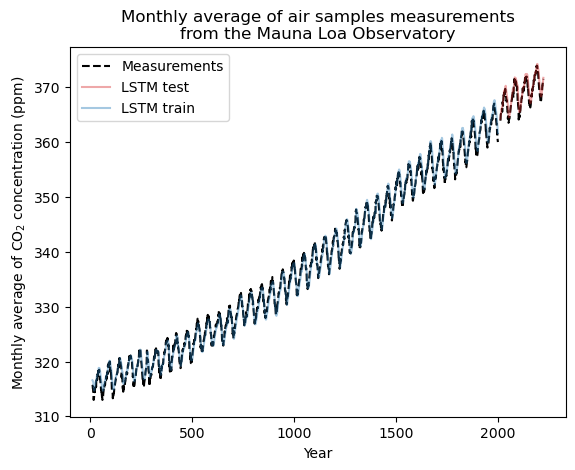

In [10]:
plt.plot(unscale(Y_train), color="black", linestyle="dashed", label="Measurements")
plt.plot(unscale(Y_test), color="black", linestyle="dashed")
plt.plot(_test_shifts.index, unscale(test_preds), color="tab:red", alpha=0.4, label="LSTM test")
plt.plot(_train_shifts.index, unscale(train_preds), color="tab:blue", alpha=0.4, label="LSTM train")
plt.setp(plt.gca(), xlabel="Year", ylabel="Monthly average of CO$_2$ concentration (ppm)", title="Monthly average of air samples measurements\nfrom the Mauna Loa Observatory")
plt.legend()